# Managing ML Experimentation using Amazon SageMaker Search
_**Organize, track and evaluate model training runs**_

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Data ingestion](#Data-ingestion)
  3. [Data inspection](#Data-inspection)
  4. [Data conversion](#Data-conversion)
3. [Training the linear model](#Training-the-linear-model)
  1. [Conduct first model training experiment](#Conduct-first-model-training-experiment)
  2. [Conduct second model training experiment](#Conduct-second-model-training-experiment)
  3. [Conduct third model training experiment](#Conduct-third-model-training-experiment)
4. [Use Amazon SageMaker Search to organize and evaluate experiments](#Use-Amazon-SageMaker-Search-to-organize-and-evaluate-experiments)
    1. [Visualize the leaderboard](#Visualize-the-leaderboard)
5. [Set up hosting for the model](#Set-up-hosting-for-the-model)
6. [Validate the model for use](#Validate-the-model-for-use)
7. [Tracing the lineage of a model starting from an endpoint](#Tracing-the-lineage-of-a-model-starting-from-an-endpoint)
    1. [Visualize the training job details](#Visualize-the-training-job-details)


# Introduction

Welcome to our example introducing Amazon SageMaker Search!  Amazon SageMaker Search lets you quickly find and evaluate the most relevant model training runs from potentially hundreds and thousands of your Amazon SageMaker model training jobs.
Developing a machine learning model requires continuous experimentation, trying new learning algorithms and tuning hyper parameters, all the while observing the impact of such changes on model performance and accuracy. This iterative exercise often leads to explosion of hundreds of model training experiments and model versions, slowing down the convergence and discovery of “winning” model. In addition, the information explosion makes it very hard down the line to trace back the lineage of a model version i.e. the unique combination of datasets, algorithms and parameters that brewed that model in the first place. 

We will show you how to use Amazon SageMaker Search to quickly and easily organize, track and evaluate your model training jobs on Amazon SageMaker. You can search on all the defining attributes from the learning algorithm used, hyper parameter settings, training datasets used to even the tags you have added on the model training jobs. You can also quickly compare and rank your training runs based on their performance metrics, such as training loss and validation accuracy, thus creating leaderboards for identifying “winning” models that can be deployed into production environments. 

Finally we will show you an example using Amazon SageMaker search for quickly tracing back the complete lineage of a model version deployed in a live environment, right up until the data sets used in training and validating the model.

The model that we will train today uses the [Amazon SageMaker Linear Learner Algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html). We're analyzing the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset which consists of images of handwritten digits, from zero to nine.  We'll use the individual pixel values from each 28 x 28 grayscale image to predict a yes or no label of whether the digit is a 0 or some other digit (1, 2, 3, ... 9).

The method that we'll use is a linear binary classifier. Linear models are supervised learning algorithms used for solving either classification or regression problems.  As input, the model is given labeled examples ( **`x`**, `y`). **`x`** is a high dimensional vector and `y` is a numeric label.  Since we are doing binary classification, the algorithm expects the label to be either 0 or 1.  The algorithm learns a linear threshold function for classification, mapping the vector **`x`** to an approximation of the label `y`.

## Prequisites and Preprocessing

### Permissions and environment variables
_This notebook was created and tested on an ml.t2.medium notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  
- A tag that acts as a **unique label** to track all the model training runs as we experiment with different hyperparameter values. Tags give you a flexible way to assign and associate your model training experiments with a specific business project, a research lab or a data science team, thus letting you meaningfully categorize and catalog your model training experiments
- The name of the endpoint where we will finally deploy the "winning" model 

In [15]:
import sagemaker
import datetime

def current_time():
    ct = datetime.datetime.now()
    return str(ct.now()).replace(":", "-").replace(" ", "-")[:19]


sess = sagemaker.Session()
bucket = sess.default_bucket()

prefix = "sagemaker/DEMO-linear-mnist"

# replace with a tag key and value of your choice
tagKey = "Project"
tagValue = "Project_Binary_Classifier"

# name for endpoint where the winning model will be depoloyed
endpointName = "linear-learner-" + current_time()

# Define IAM role
import boto3
from sagemaker import get_execution_role

role = get_execution_role()

print(role)
print(endpointName)

arn:aws:iam::688520471316:role/hongshan-sagemaker-experiment
linear-learner-2021-06-16-18-34-22


### Data ingestion
Next, we read the dataset from an online URL into memory, for preprocessing prior to training. For small datasets, such as this one, reading into memory isn't onerous.

In [10]:
!aws s3 cp s3://sagemaker-sample-files/datasets/image/MNIST/mnist.pkl.gz .

download: s3://sagemaker-sample-files/datasets/image/MNIST/mnist.pkl.gz to ./mnist.pkl.gz


In [11]:
%%time
import pickle, gzip, numpy, urllib.request, json

with gzip.open("mnist.pkl.gz", "rb") as f:
    train_set, valid_set, test_set = pickle.load(f, encoding="latin1")

CPU times: user 642 ms, sys: 244 ms, total: 886 ms
Wall time: 885 ms


### Data inspection
Once the dataset is imported, it's typical as part of the machine learning process to inspect the data. As an example, let's go ahead and look at one of the digits that is part of the dataset.

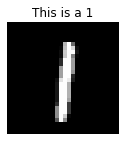

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (2, 10)


def show_digit(img, caption="", subplot=None):
    if subplot == None:
        _, (subplot) = plt.subplots(1, 1)
    imgr = img.reshape((28, 28))
    subplot.axis("off")
    subplot.imshow(imgr, cmap="gray")
    plt.title(caption)


show_digit(train_set[0][40], "This is a {}".format(train_set[1][40]))

### Data conversion
The Amazon SageMaker implementation of Linear Learner takes recordIO-wrapped protobuf, where the data we have today is a pickle-ized numpy array on disk. So we will perform data conversion using the Amazon SageMaker Python SDK, imported as `sagemaker` below.

In [44]:
import io
import numpy as np
import sagemaker.amazon.common as smac

vectors = np.array([t.tolist() for t in train_set[0]]).astype("float32")
labels = np.where(np.array([t.tolist() for t in train_set[1]]) == 0, 1, 0).astype("float32")

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)

with open('recordio-pb-data', 'wb') as f:
    f.write(buf.read())

### Upload training data
Now that we've created our recordIO-wrapped protobuf, we'll need to upload it to S3, so that Amazon SageMaker training can use it.

In [45]:
import boto3
import os

key = "recordio-pb-data"
boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "train", key)).upload_file("recordio-pb-data")
s3_train_data = "s3://{}/{}/train/{}".format(bucket, prefix, key)
print("uploaded training data location: {}".format(s3_train_data))

uploaded training data location: s3://sagemaker-us-west-2-688520471316/sagemaker/DEMO-linear-mnist/train/recordio-pb-data


In [46]:
!aws s3 ls s3://sagemaker-us-west-2-688520471316/sagemaker/DEMO-linear-mnist/train/recordio-pb-data

2021-06-16 19:29:16  159200000 recordio-pb-data


Let's also setup an output S3 location for the model artifact that will be output as the result of training with the algorithm.

In [47]:
output_location_1 = "s3://{}/{}/output-1".format(bucket, prefix)
print("training artifacts will be uploaded to: {}".format(output_location_1))

training artifacts will be uploaded to: s3://sagemaker-us-west-2-688520471316/sagemaker/DEMO-linear-mnist/output-1


# Training the linear model
Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. First, let's specify our algorithm container. More details on algorithm containers can be found in [AWS documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html).

In [48]:
from sagemaker.image_uris import retrieve
container = retrieve("linear-learner", boto3.Session().region_name)
print("model will be trained using the container: " + str(container))

model will be trained using the container: 174872318107.dkr.ecr.us-west-2.amazonaws.com/linear-learner:1


### Conduct first model training experiment
We'll use the Amazon SageMaker Python SDK to kick off training, and monitor status until it is completed.  In this example that takes between 7 and 11 minutes. Make sure to pass in the necessary hyperparameters:
- `feature_dim` is set to 784, which is the number of pixels in each 28 x 28 image.
- `predictor_type` is set to 'binary_classifier' since we are trying to predict whether the image is or is not a 0.
- `mini_batch_size` is set to 100. Selecting a reasonable value relative to the dataset is appropriate in most cases.

In our first model training expriment we are setting the mini_batch_size as 100. We will experiment further with values of 200 and 300 as well and then use Amazon SageMaker Search to organize and evaluate the three model training runs. 

In [49]:
import boto3
import sagemaker

smclient = boto3.client(service_name="sagemaker")
sess = sagemaker.session.Session(sagemaker_client=smclient)

linear_1 = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path=output_location_1,
    tags=[{"Key": tagKey, "Value": tagValue}],
    #sagemaker_session=sess,
)

linear_1.set_hyperparameters(
    feature_dim=784, predictor_type="binary_classifier", mini_batch_size=200
)

linear_1.fit({"train": s3_train_data})

2021-06-16 19:33:10 Starting - Starting the training job...
2021-06-16 19:33:33 Starting - Launching requested ML instancesProfilerReport-1623871989: InProgress
...
2021-06-16 19:34:08 Starting - Preparing the instances for training.........
2021-06-16 19:35:33 Downloading - Downloading input data...
2021-06-16 19:35:59 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/16/2021 19:36:03 INFO 139835354720064] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias'

### Conduct second model training experiment
Now we'll try the mini_batch_size of 200 and train another version of our binary classifier model. Also note that we are using the same tag to label all our experiments so that we can group them later for comparison and analysis. 

In [50]:
# S3 location for second model version
output_location_2 = "s3://{}/{}/output-2".format(bucket, prefix)

linear_2 = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path=output_location_2,
    tags=[{"Key": tagKey, "Value": tagValue}],
    sagemaker_session=sess,
)

linear_2.set_hyperparameters(
    feature_dim=784, predictor_type="binary_classifier", mini_batch_size=200
)

linear_2.fit({"train": s3_train_data})

2021-06-16 19:39:57 Starting - Starting the training job...
2021-06-16 19:40:21 Starting - Launching requested ML instancesProfilerReport-1623872397: InProgress
......
2021-06-16 19:41:21 Starting - Preparing the instances for training.........
2021-06-16 19:42:46 Downloading - Downloading input data...
2021-06-16 19:43:23 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/16/2021 19:43:28 INFO 140386907043648] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_b

### Conduct third model training experiment
Now we'll try the mini_batch_size of 300 and train another version of our binary classifier model.

In [51]:
# S3 location for third model version
output_location_3 = "s3://{}/{}/output-3".format(bucket, prefix)

linear_3 = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path=output_location_3,
    tags=[{"Key": tagKey, "Value": tagValue}],
    sagemaker_session=sess,
)

linear_3.set_hyperparameters(
    feature_dim=784, predictor_type="binary_classifier", mini_batch_size=300
)

linear_3.fit({"train": s3_train_data})

2021-06-16 19:46:12 Starting - Starting the training job...
2021-06-16 19:46:35 Starting - Launching requested ML instancesProfilerReport-1623872772: InProgress
...
2021-06-16 19:47:10 Starting - Preparing the instances for training............
2021-06-16 19:49:10 Downloading - Downloading input data...
2021-06-16 19:49:42 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/16/2021 19:49:47 INFO 140152143054656] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_b

# Use Amazon SageMaker Search to organize and evaluate experiments
Usually you will experiment with tuning multiple hyperparameters or even try new learning algorithms and training datasets resulting in potentially hundreds of model training runs and model versions. However, for the sake of simplicity, we are only tuning mini_batch_size in this example, trying only three different values resulting in as many model versions. Now we will use [Search](https://docs.aws.amazon.com/sagemaker/latest/dg/search.html) to **group together** the three model training runs and **evaluate** the best performing model by ranking and comparing them on a metric of our choice. 

**For grouping** the relevant model training runs together, we will search the model training jobs by the unique label or tag that we have been using as a tracking label to track our experiments.  

**For model evaluation**, Amazon SageMaker Linear Learner Algorithm emits variety of [metrics](https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner-tuning.html) that are automatically published to Amazon CloudWatch for monitoring and visualization. You can easily graph timeseries curves such as training curves and validation curves. If you are training your own algorithm, you can [specify the metrics](https://docs.aws.amazon.com/sagemaker/latest/dg/training-metrics.html) that you want Amazon SageMaker to monitor and publish to Amazon CloudWatch. 

For the sake of this example, we will compare the three binary classification model versions models we created before on the final value of objective_loss metric evaluated on the MNIST training dataset. We will rank model training runs by their objective_loss in ascending order, thus putting the best performing model on the top.

In [52]:
import boto3
import pandas
import numpy as np

search_params = {
    "MaxResults": 10,
    "Resource": "TrainingJob",
    "SearchExpression": {
        "Filters": [
            {"Name": "Tags." + str(tagKey), "Operator": "Equals", "Value": tagValue},
            {"Name": "TrainingJobStatus", "Operator": "Equals", "Value": "Completed"},
        ]
    },
    "SortBy": "Metrics.train:objective_loss:final",
    "SortOrder": "Ascending",
}

smclient = boto3.client(service_name="sagemaker")
results = smclient.search(**search_params)
print("The search query returned " + str(len(results["Results"])) + " training jobs.\n")

The search query returned 3 training jobs.



### Visualize the leaderboard
For ease of comparison, we will print a **leaderboard** of model training runs that displays the best performing model on the top. We will also print a scatter plot as an example of alternative way for visualizing the impact of changing the mini_batch_size on model performance. 

,Training Job Name,Training Job Status,Mini Batch Size,Objective Loss
0,linear-learner-2021-06-16-19-33-09-882,Completed,200,0.022991
1,linear-learner-2021-06-16-19-39-57-583,Completed,200,0.022991
2,linear-learner-2021-06-16-19-46-12-428,Completed,300,0.023285


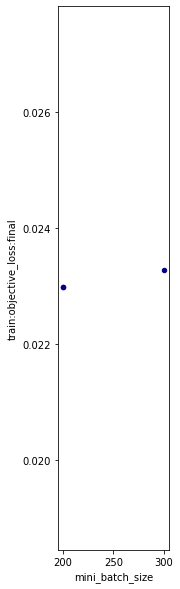

In [53]:
# Now we will print the leaderboard and scatter plot
rows = []
coord = []
for result in results["Results"]:
    trainingJob = result["TrainingJob"]
    metrics = trainingJob["FinalMetricDataList"]
    accuracy = metrics[[x["MetricName"] for x in metrics].index("train:objective_loss:final")][
        "Value"
    ]
    rows.append(
        [
            trainingJob["TrainingJobName"],
            trainingJob["TrainingJobStatus"],
            trainingJob["HyperParameters"]["mini_batch_size"],
            accuracy,
        ]
    )
    coord.append([float(trainingJob["HyperParameters"]["mini_batch_size"]), accuracy])

headers = ["Training Job Name", "Training Job Status", "Mini Batch Size", "Objective Loss"]
df = pandas.DataFrame(data=rows, columns=headers)
from IPython.display import HTML

display(HTML(df.to_html()))

axes = ["mini_batch_size", "train:objective_loss:final"]
df = pandas.DataFrame(data=coord, columns=axes)
ax1 = df.plot.scatter(x="mini_batch_size", y="train:objective_loss:final", c="DarkBlue")
ax1

# Set up hosting for the model
Now that we've found our best performing model (in this example the one with mini_batch_size=100), we can deploy it behind an Amazon SageMaker real-time hosted endpoint.  This will allow out to make predictions (or inference) from the model dyanamically.

In [ ]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

linear_predictor = linear_1.deploy(
    initial_instance_count=1, 
    instance_type="ml.m4.xlarge", 
    endpoint_name=endpointName,
    serializer=CSVSerializer(),
    deserializer=JSONDeserializer()
)

----

In [ ]:
result = linear_predictor.predict(train_set[0][30:31])
print(result)

# Tracing the lineage of a model starting from an endpoint
Now we will present an example of how you can use the Amazon SageMaker Search to trace the antecedents of a model deployed at an endpoint i.e. unique combination of algorithms, datasets, and parameters that brewed the model in first place.

In [ ]:
# first get the endpoint config for the relevant endpoint
endpoint_config = smclient.describe_endpoint_config(EndpointConfigName=endpointName)

# now get the model name for the model deployed at the endpoint.
# in this case we know that there is only one model version (aka Production Variant) deployed at the endpoint
model_name = endpoint_config["ProductionVariants"][0]["ModelName"]

# now look up the S3 URI of the model artifacts
model = smclient.describe_model(ModelName=model_name)
modelURI = model["PrimaryContainer"]["ModelDataUrl"]
print(str(modelURI))

# search for the training job that created the model artifacts at above S3 URI location
search_params = {
    "MaxResults": 1,
    "Resource": "TrainingJob",
    "SearchExpression": {
        "Filters": [
            {"Name": "ModelArtifacts.S3ModelArtifacts", "Operator": "Equals", "Value": modelURI}
        ]
    },
}

results = smclient.search(**search_params)
print("The search query returned " + str(len(results["Results"])) + " training jobs.\n")

### Visualize the training job details
For ease of visualization, we will now print all the relevant details of the model training job such as the learning algorithm used, chosen hyperparameter values and training dataset used in creating the model

In [ ]:
# now print all the relevant model training details such as algorithm used, training dataset URI, hyper parameter settings
# and performance metrics recorded during the training run
trainingJob = results["Results"][0]["TrainingJob"]
metrics = trainingJob["FinalMetricDataList"]
metricnames = [x["MetricName"] for x in metrics]
metricvalues = [x["Value"] for x in metrics]
hyperparams = trainingJob["HyperParameters"]

headers = (
    ["Training Job Name", "Training Datasource URI", "Training Algorithm"]
    + list(hyperparams.keys())
    + metricnames
)
rows = []
rows.append(
    [
        trainingJob["TrainingJobName"],
        trainingJob["InputDataConfig"][0]["DataSource"]["S3DataSource"]["S3Uri"],
        trainingJob["AlgorithmSpecification"]["TrainingImage"],
    ]
    + list(hyperparams.values())
    + metricvalues
)

df = pandas.DataFrame(data=rows, columns=headers)

# Set CSS properties for th elements in dataframe
th_props = [
    ("font-size", "11px"),
    ("text-align", "center"),
    ("font-weight", "bold"),
    ("color", "#6d6d6d"),
    ("background-color", "#f7f7f9"),
]

# Set CSS properties for td elements in dataframe
td_props = [("font-size", "11px"), ("text-align", "center")]

# Set table styles
styles = [dict(selector="th", props=th_props), dict(selector="td", props=td_props)]
html = df.style.set_table_styles(styles)
from IPython.display import display, HTML

html

### (Optional) Delete the Endpoint

If you're ready to be done with this notebook, please run the delete_endpoint line in the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
import sagemaker

sagemaker.Session().delete_endpoint(linear_predictor.endpoint)